<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/Biomate_NN_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import tqdm
from time import time

# Estructura de los datos.

Consideramos un caso general, una base con datos de frecuencias de especies, cada observación de dimensión $k$, y supongamos que tenemos $n$ observaciones.

El output busca ser la clasificación en una de $d$ categorías, definidas ya sea por ciudad o localización-clima (pero de un sólo tipo).


# Datos de ejemplo

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("Dataset_w_tags.csv")
df.head()
from sklearn.utils import shuffle
df = shuffle(df)###El ajuste depende de este shuffle*****

In [61]:
print(df.shape)

(237, 513)


Se tienen 237 observaciones, cada una es una muestra en una "localización".
Por renglón, se tienen frecuencias de "bichos" de 510 "dominant taxa".

En este caso, $k=510$, $n=237$.

In [62]:
ytags=df['Tag']
print(ytags)

219    Temperate forests_0
144       Dry grasslands_3
148               Boreal_5
233         Cold forests_3
97           Dry forests_0
              ...         
55          Cold forests_6
89           Dry forests_0
80           Dry forests_0
61          Cold forests_6
222    Temperate forests_0
Name: Tag, Length: 237, dtype: object


In [63]:
ytags

219    Temperate forests_0
144       Dry grasslands_3
148               Boreal_5
233         Cold forests_3
97           Dry forests_0
              ...         
55          Cold forests_6
89           Dry forests_0
80           Dry forests_0
61          Cold forests_6
222    Temperate forests_0
Name: Tag, Length: 237, dtype: object

In [64]:
import numpy as np
_,idx = np.unique(ytags,return_inverse=True)

Dados los datos con su respectiva clasificación. (En el ejemplo $d=12$)


Lamentablemente los datos tienen clases sub-representadas

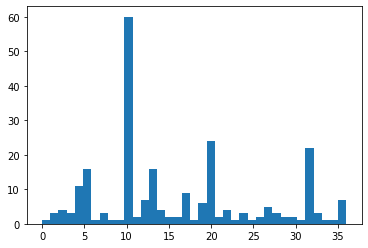

In [65]:
plt.hist(idx,bins=37)
plt.show()#Mala representatividad de clases.

# Definición del modelo.

# Partición de datos

In [66]:
from keras.utils import to_categorical
X_total=df.drop(columns=['Tag','Dominant_taxa_ID/ID_Environmental'])
Y_total=to_categorical(idx)

In [67]:
X_train=X_total[0:200]
Y_train=Y_total[0:200]

In [68]:
df.head()
k,n=X_train.shape
n=n#-indice, -tag
print(k,n)

200 511


In [69]:
input_shape = (n,)#=n
output_shape=len(np.unique(ytags))

In [70]:
import tensorflow as tf
import keras
import pandas as pd
from keras import layers
from keras import models


# Capas, neuronas, funciones de activación, loss.

In [72]:
model = models.Sequential()

model.add(layers.InputLayer(input_shape=(n,), name='Input_Layer'))#Obligatoria
model.add(layers.Dense(10, activation='relu'))# Numero de capas ocultas: Opcional
model.add(layers.Dense(10, activation='relu'))# Numero de neuronas en cada capa: Opcional
model.add(layers.Dense(37, activation='Softmax', name='Output_Layer'))#Obligatoria
model.summary()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
import time
tic = time.time()

model.fit(x = X_train, 
           y = Y_train, 
          validation_data=[X_total[200:], Y_total[200:]],
          batch_size=50,
           epochs=200,
           verbose=2,shuffle=True)

print('seconds=', time.time()-tic)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 10)                5120      
                                                                 
 dense_15 (Dense)            (None, 10)                110       
                                                                 
 Output_Layer (Dense)        (None, 37)                407       
                                                                 
Total params: 5,637
Trainable params: 5,637
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
4/4 - 1s - loss: 10.6835 - accuracy: 0.0200 - val_loss: 7.5658 - val_accuracy: 0.0270 - 1s/epoch - 267ms/step
Epoch 2/200
4/4 - 0s - loss: 6.3449 - accuracy: 0.0300 - val_loss: 5.7665 - val_accuracy: 0.0000e+00 - 142ms/epoch - 36ms/step
Epoch 3/200
4/4 - 0s - loss: 4.7748 - accuracy: 0.0200 - val_loss: 

In [13]:
model.save('primer_intento.h5')

In [17]:
import numpy as np

test_predicted_labels = model.predict(X_total[200:])
test_true_labels      = np.argmax(Y_total[200:],axis=1)
test_predicted_labels = np.argmax(test_predicted_labels,axis=1)

2/2 [==============================] - 0s 7ms/step


In [ ]:
#Podríamos implementar metricas, accuracy, recall, F1, AUC, etc.

# Segundo intento. Leave One Out Cross Validation Method.

Sean $X_1,X_2,\ldots, X_n$ las observaciones. 
Para cada $i\in\{1,2,\ldots,n\}$ se define una red $RN(i)$, que es entrenada con los datos 
$$X_{train}^{(i)}=\{X\}_{i=1}^n - \{X_i\}$$
$$X_{val}^{(i)}=\{X_i\}$$


Sea $Y_{pred}^{(i)}=RN(i)(X_i)$ la predicción del dato de entrenamiento.

Para cada $i$, se obtiene un error $\epsilon_i\in\{0,1\}$.

Definimos una precisión global como 
$$\frac{1}{n}\sum_{i=1}^n \epsilon_i$$

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical

df = pd.read_csv("Dataset_w_tags.csv")
df.head()
y_tags=df['Tag']
df_X=df.drop(columns=['Tag','Dominant_taxa_ID/ID_Environmental'])
_,idx_Total = np.unique(y_tags,return_inverse=True)
#from sklearn.utils import shuffle
#df = shuffle(df)###El ajuste depende de este shuffle

(array([ 1.,  3.,  4.,  3., 11., 16.,  1.,  3.,  1.,  1., 60.,  2.,  7.,
        16.,  4.,  2.,  2.,  9.,  1.,  6., 24.,  2.,  4.,  1.,  3.,  1.,
         2.,  5.,  3.,  2.,  2.,  1., 22.,  3.,  1.,  1.,  7.]),
 array([ 0.        ,  0.97297297,  1.94594595,  2.91891892,  3.89189189,
         4.86486486,  5.83783784,  6.81081081,  7.78378378,  8.75675676,
         9.72972973, 10.7027027 , 11.67567568, 12.64864865, 13.62162162,
        14.59459459, 15.56756757, 16.54054054, 17.51351351, 18.48648649,
        19.45945946, 20.43243243, 21.40540541, 22.37837838, 23.35135135,
        24.32432432, 25.2972973 , 26.27027027, 27.24324324, 28.21621622,
        29.18918919, 30.16216216, 31.13513514, 32.10810811, 33.08108108,
        34.05405405, 35.02702703, 36.        ]),
 <a list of 37 Patch objects>)

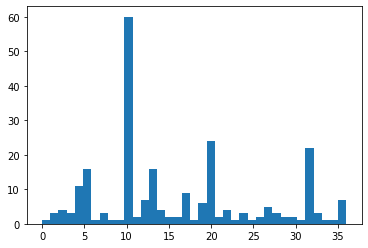

In [9]:
plt.hist(idx_Total,bins=37)

Observamos que en esta base con pocas muestras, hay clases con un único representante, por lo que no tiene sentido dejarlo fuera pues disminuiría el número de clases y por lo tanto una correcta clasificación tiene inmediatamente probabilidad cero.

Como solución improvisada, haremos réplica (¿cuántas veces?) de muestras para aquellas clases con muy pocas (¿cuántas son muy pocas?), para incrementar la representatividad. 

Esto es equivalente a agregarle pesos de clasificación a estas clases, y un caso extremo sería homogeneizar los números de observaciones por clase de manera que una nueva muestra tenga probabilidad uniforme de provenir de una de las clases. (cita_pendiente)

In [12]:
uniques,ocurr=np.unique(idx_Total,return_counts=True)
indices_w_varios=[]
for k in range(len(ocurr)):
    if ocurr[k]<=2:#Indices de la base donde hay pocos 
        indices=np.where(idx_Total==k)[0]
        df=df.append(df.loc[indices],ignore_index=True)
        print(indices)
df2=pd.DataFrame(df)

[148]
[31]
[16]
[66]
[142 143]
[155 157]
[152 153]
[25]
[133 134]
[17]
[5]
[158 161]
[154 156]
[200 204]
[210]
[0]
[8]


In [4]:
y_tags_2=df2['Tag']
df2_X=df2.drop(columns=['Tag','Dominant_taxa_ID/ID_Environmental'])
a_a,idx2_Total = np.unique(y_tags_2,return_inverse=True)

In [5]:
uniques2,ocurr2=np.unique(idx2_Total,return_counts=True)
print(ocurr2)

[ 2  3  4  3 11 16  2  3  2  2 60  4  7 16  4  4  4  9  2  6 24  4  4  2
  3  2  4  5  3  4  4  2 22  3  2  2  7]


Ya no hay clases con únicos elementos ni con solo 2.

In [20]:
import tensorflow as tf
import keras
import pandas as pd
from keras import layers
from keras import models
from keras.utils import to_categorical

batch_size_fijo=10
epochs_fijas=10
def RN(i):#Recibe $i\in\{0,\ldots,n\}$
    X_total=df2_X
    Y_total=idx2_Total
    X_train_i=X_total.drop(index=i)
    Y_train_i=to_categorical(np.delete(Y_total,i))
    X_val=X_total.loc[i]
    Y_val=idx2_Total[i]###Que sea de tipo categorical_keras
    Y_val_cat=np.zeros(len(uniques))
    Y_val_cat[Y_val]=1
    
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(511,), name='Input_Layer'))#Obligatoria
    model.add(layers.Dense(512, activation='relu'))# Numero de capas ocultas: Opcional
    model.add(layers.Dense(64, activation='relu'))# Numero de neuronas en cada capa: Opcional
    model.add(layers.Dense(37, activation='Softmax', name='Output_Layer'))#Obligatoria
    #model.summary()
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.
    if(i==0):  
        model.fit(x = X_train_i, 
            y = Y_train_i,
            batch_size=batch_size_fijo,
            epochs=epochs_fijas,
            verbose=2,shuffle=True,callbacks=[callback])
    else: 
        model.fit(x = X_train_i, 
        y = Y_train_i,
        batch_size=batch_size_fijo,
        epochs=epochs_fijas,
        verbose=0,shuffle=True,callbacks=[callback])
    #Asumimos que se terminó de entrenar
    return model

Error encontrado: Cuando consideramos suficientes neuronas, podemos conseguir un error de clasificación de los datos de entrenamiento muy cerca del 100%. Esto último se puede identificar como una memorización de estos datos, por lo que la clasificación de nuevos climas sólo tiene sentido para los datos con más de 2 elementos.

Se puede considerar una red más sencilla, con menos neuronas de manera que no se aprenda los datos de entrenamiento, sacrificando precisión pero buscando generalidad.

In [21]:
indices_prueba

array([  0,  57, 201, 160, 111, 200,  94,  36, 116,  28,   6, 245, 240,
       114,  56,  54,   1, 225, 243, 125,  33, 136, 187, 236,  14, 167,
       117,  31, 190, 139, 108, 134,  98,  35, 166, 208, 156, 169,  64,
       180,  37,  50,  46, 109, 242,  92, 229,  82, 209, 126])

In [33]:
X_total=df2_X
Y_total=idx2_Total
pred_trues=[]
test_true_labels = np.argmax(to_categorical(Y_total),axis=1)
indices_prueba=np.random.choice(range(0,len(X_total)),size=200,replace=False)
test_pred_glob=[]
if(0 not in indices_prueba):
    indices_prueba[0]=0
for i in indices_prueba:
    test_predicted_labels = RN(i).predict(X_total)
    test_predicted_labels = np.argmax(test_predicted_labels,axis=1)
    test_pred_glob.append(test_predicted_labels[i])


9/9 [==============================] - 0s 2ms/step
Epoch 1/10
26/26 - 0s - loss: 7.8510 - accuracy: 0.3077 - 390ms/epoch - 15ms/step
Epoch 2/10
26/26 - 0s - loss: 2.2488 - accuracy: 0.4231 - 54ms/epoch - 2ms/step
Epoch 3/10
26/26 - 0s - loss: 1.6937 - accuracy: 0.5308 - 63ms/epoch - 2ms/step
Epoch 4/10
26/26 - 0s - loss: 1.2945 - accuracy: 0.6346 - 63ms/epoch - 2ms/step
Epoch 5/10
26/26 - 0s - loss: 0.9799 - accuracy: 0.7038 - 55ms/epoch - 2ms/step
Epoch 6/10
26/26 - 0s - loss: 0.8311 - accuracy: 0.7423 - 56ms/epoch - 2ms/step
Epoch 7/10
26/26 - 0s - loss: 0.5924 - accuracy: 0.8154 - 54ms/epoch - 2ms/step
Epoch 8/10
26/26 - 0s - loss: 0.5233 - accuracy: 0.8346 - 55ms/epoch - 2ms/step
Epoch 9/10
26/26 - 0s - loss: 0.5426 - accuracy: 0.8462 - 54ms/epoch - 2ms/step
Epoch 10/10
26/26 - 0s - loss: 0.4434 - accuracy: 0.8731 - 54ms/epoch - 2ms/step
9/9 [==============================] - 0s 2ms/step


In [36]:
test_true_global=test_true_labels[indices_prueba]
np.sum(test_pred_glob==test_true_global)/200

0.625

Obtuvimos una precisión de aproximadamente 60% para datos de validación (global).


In [49]:
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score,confusion_matrix, precision_score, recall_score,roc_auc_score

from sklearn.metrics import f1_score, cohen_kappa_score
import seaborn as sns 

accuracy = accuracy_score(test_true_global, test_pred_glob)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_true_global, test_pred_glob,average='weighted',zero_division=1)
print('Precision: %f',precision)
# recall: tp / (tp + fn)
recall = recall_score(test_true_global, test_pred_glob,average='weighted',zero_division=1)
print('Recall: %f' , recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_true_global, test_pred_glob,average='weighted')
print('F1 score: %f' % f1)


Accuracy: 0.625000
Precision: %f 0.6526153846153846
Recall: %f 0.625
F1 score: 0.616362
